In [1]:
import requests
import pandas as pd
from pandas import read_html
import matplotlib.pyplot as plt

In [2]:
def get_odstavky(df,od,do):
    indexes = df['Event Start']
    df.index= indexes
    dat = df

    dat.index = dat.index.astype('string').str.split('+',expand=True).droplevel(1)
    dat.index = pd.to_datetime(dat.index)

    dat['Event Start'] = dat['Event Start'].astype('string').str.split('+',expand=True).iloc[:,0]
    dat['Event Start'] = pd.to_datetime(dat['Event Start'])
    dat['Event Start'] = dat['Event Start'].round('H')
    dat['Event Stop'] = dat['Event Stop'].astype('string').str.split('+',expand=True).iloc[:,0]
    dat['Event Stop'] = pd.to_datetime(dat['Event Stop'])
    dat['Event Stop'] = dat['Event Stop'].round('H')

    dat['Odstavka'] = dat['Technical Capacity'] - dat['Available Capacity']

    lst = pd.date_range(start = od, end = do,freq = '1H')
    df2 = pd.DataFrame(0, index = lst, columns = dat['Affected Asset or Unit'].unique())

    for col in df2.columns:
        for date in df2.index:
            mask = (dat['Event Start'] < date) & (dat['Event Stop'] > date) & (dat['Affected Asset or Unit'] == col)
            df2.loc[date,col] = dat.loc[mask]['Odstavka'].sum()
    
    df2["Odstavka"] = df2.sum(axis=1)
    df2 = df2[["Odstavka"]]
    df2["Retrieved"] = pd.to_datetime("today").strftime("%Y-%m-%d")
    return df2

In [3]:
s=requests.session()
s1=s.get("https://umm.gassco.no")
s2=s.get("https://umm.gassco.no/disclaimer/acceptDisclaimer?")
data = read_html(s2.text, attrs={"class": "msgTable"})
df = pd.DataFrame(data[0])
exit_terminals = pd.DataFrame(data[1])

In [4]:
new_df = get_odstavky(df,"2023-01-01","2024-01-01")

<AxesSubplot: >

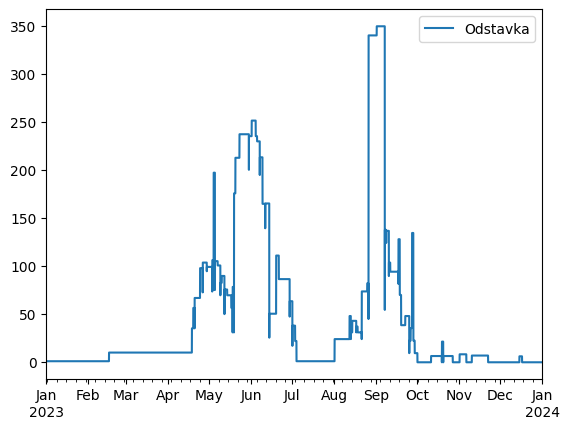

In [5]:
new_df.plot()

In [26]:
new_df.to_excel("ukažka.xlsx")

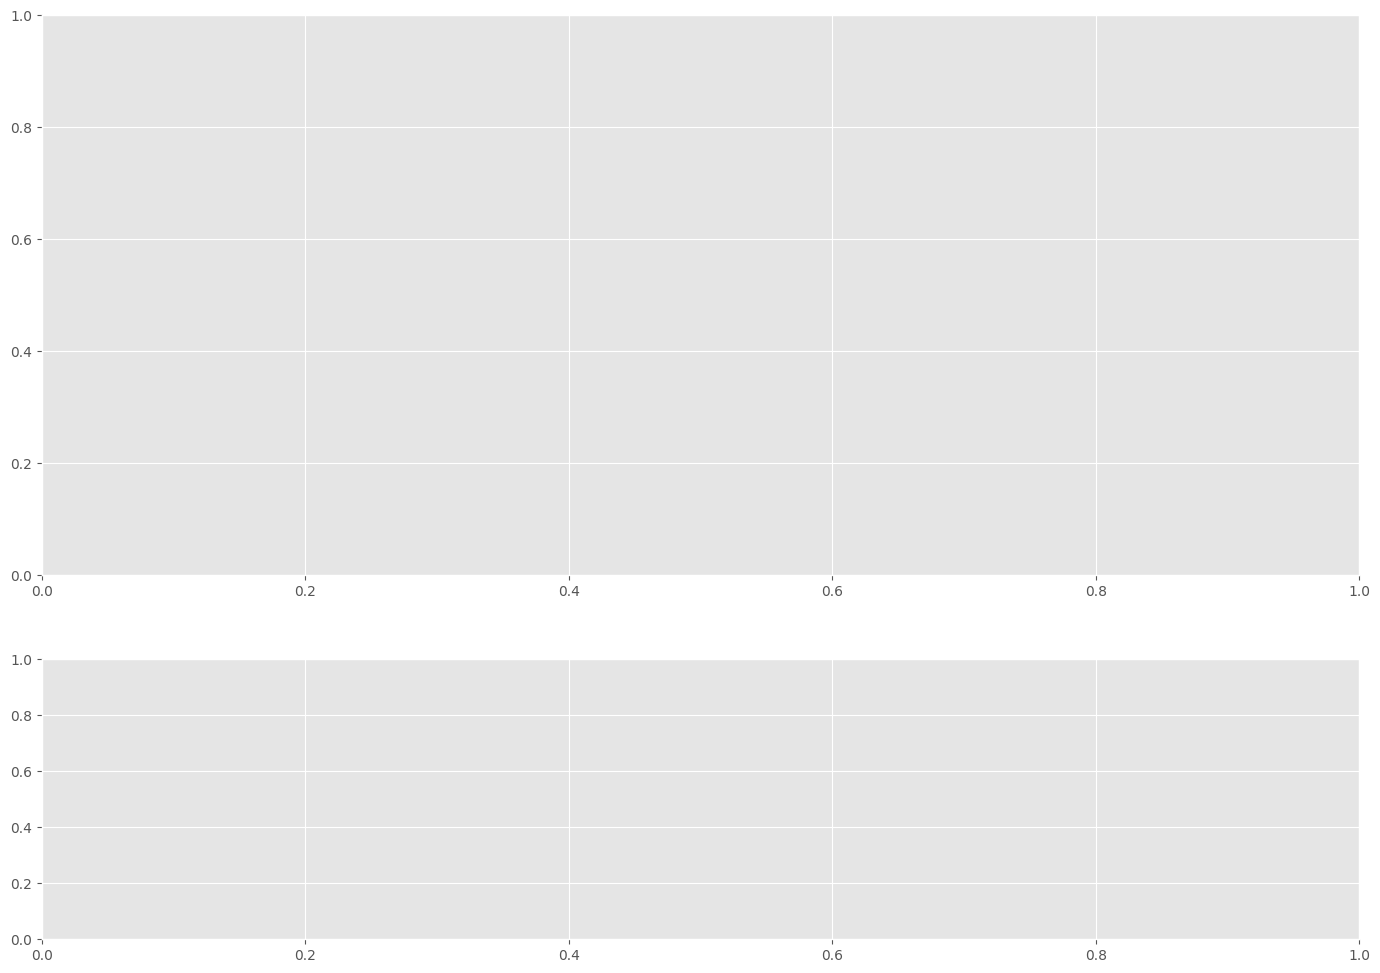

In [14]:
# plot

plt.style.use('ggplot')

fig,(ax1, ax2) = plt.subplots(2, figsize = (17,12), gridspec_kw={'height_ratios': [2, 1]})



In [15]:



# informative title + subtitle

title = 'Solar - predikcia na 45 dní'

subtitle = 'Porovnanie predikcií - EC-ext 00:00 45D pre DE'



Text(0.1, 0.88, 'Porovnanie predikcií - EC-ext 00:00 45D pre DE')

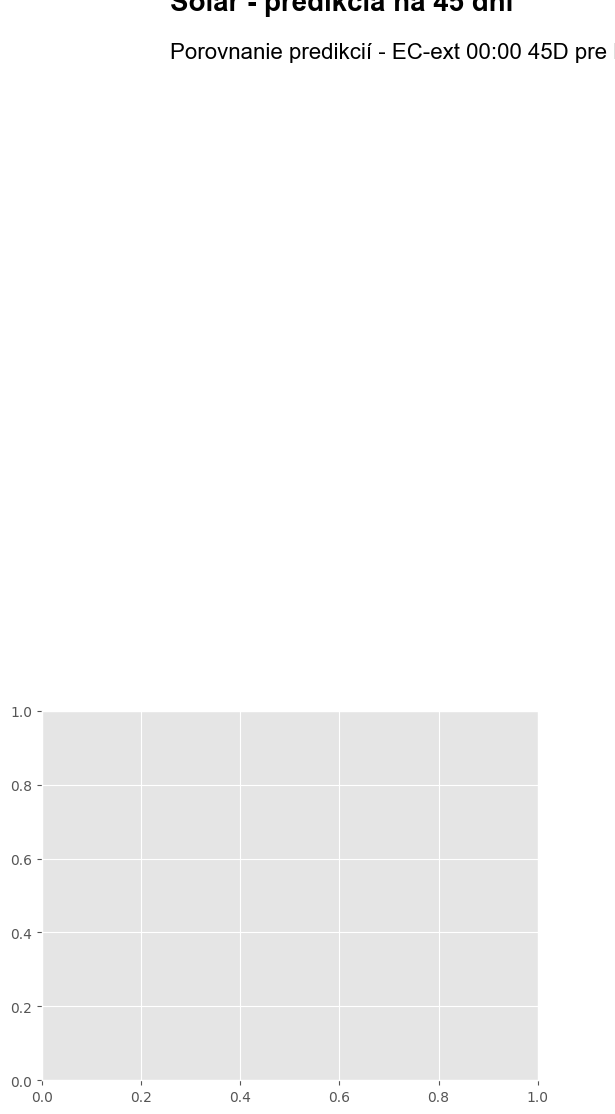

In [16]:



# add title + subtitle to plot

plt.text(
x = 0.1,y = 0.92,s = title,fontname = 'Arial',
fontsize = 20,fontweight='bold', ha='left',transform = fig.transFigure
)

plt.text(
x = 0.1,y = 0.88,s = subtitle,fontname = 'Arial',
fontsize = 16,ha = 'left',transform = fig.transFigure
)


In [17]:
ax1.plot(df.index, df.iloc[:,2], label = df.columns[2],linewidth=2.5)
ax1.plot(df.index, df.iloc[:,3], label = df.columns[3], linestyle = '--',linewidth=2)
ax1.plot(df.index, df.iloc[:,0], label = df.columns[0],linewidth=5, alpha = 0.4)
ax1.plot(df.index, df.iloc[:,1], label = df.columns[1],linewidth=2, marker = 'o',markersize=3)

ax2.plot(df.index, df.iloc[:,5], label = df.columns[5], linewidth=2)
ax2.plot(df.index, df.iloc[:,6], label = df.columns[6], linestyle = '--',linewidth=2)
ax2.plot(df.index, df.iloc[:,4], label = df.columns[4] ,linewidth=2.5)
ax2.plot(df.index, df.iloc[:,7], label = df.columns[7],linewidth=2, marker = 'o',markersize=2)

ax2.axhline(y=0, color = 'k', linewidth=2)

ax2.axhline(y = df.iloc[:,4].mean(),color = 'tab:purple', label = df.columns[4] ,linewidth=1.5)



TypeError: 'value' must be an instance of str or bytes, not a float

In [ ]:
#format y-axis
#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals = 0))

start, end = ax1.get_ylim()
ax1.yaxis.set_ticks(np.arange(0, end, 2000))
ax1.set_ylim(bottom=0)
ax1.tick_params(axis='both', which='major', labelsize=11)

In [ ]:
# misc - grid and legend
# grid lines
# keep only toned down vertical lines
ax1.grid(axis = 'y',alpha = 0.6)
plt.gca().spines[['left','right', 'top']].set_visible(False)

In [ ]:
start, end = ax2.get_ylim()
start = round(start, -3)
ax2.yaxis.set_ticks(np.arange(start, end, round((end-start)/10, -3)))

ax2.tick_params(axis='both', which='major', labelsize=11)


In [ ]:

# misc - grid and legend
# grid lines
# keep only toned down vertical lines
ax2.grid(axis = 'y',alpha = 0.6)
# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)
# fiddle with space above chart
plt.subplots_adjust(top=0.8, wspace=0.3)

In [ ]:
# line between titles and chart
plt.gca().plot(
    [0.1, .9], # x co-ords

    [.86, .86], # y co-ords

    transform = fig.transFigure,

    clip_on = False,

    color = 'k',

    linewidth = 1.5

)
# axis description

description = 'Predikcie v MWh'

plt.text(

    x = 0.1,

    y = 0.82,

    s = description,

    fontname = 'Arial',

    fontsize = 13,

    ha='left',

    transform = fig.transFigure

)

# axis description

description = 'Zmeny v MWh'

plt.text(

    x = 0.1,

    y = 0.33,

    s = description,

    fontname = 'Arial',

    fontsize = 13,

    ha='left',

    transform = fig.transFigure

)






val = round(df.iloc[:,4].mean(),-2)

ax2.annotate(

    text = f'Zmena o  {val} MWh \n vs. posledná predpoveď',

    xy = (df.index[-14],start+1500),

    textcoords = 'offset points',

    color = 'tab:purple',

    xytext = (-100,5),fontname = 'Arial',fontsize = 12

)





tod = pd.Timestamp('today').date().isoformat()

# foot note

footnote = f"Zdroj: TRA, {tod}"

plt.text(

    x = 0.1,

    y = 0.05,

    s = footnote,

    fontname = 'Arial',

    fontstyle = 'italic',

    fontsize = 10,

    ha = 'left',

    transform = fig.transFigure

)




handles, labels = ax1.get_legend_handles_labels()

newLabels, newHandles = [], []

for handle, label in zip(handles, labels):

    if label not in newLabels:

        newLabels.append(label)

        newHandles.append(handle)

ax1.legend(newHandles, newLabels, prop={'size': 11})





handles, labels = ax2.get_legend_handles_labels()

newLabels, newHandles = [], []

for handle, label in zip(handles, labels):

    if label not in newLabels:

        newLabels.append(label)

        newHandles.append(handle)

ax2.legend(newHandles, newLabels, prop={'size': 11},loc="upper right")

#plt.legend(loc="upper right")




plt.savefig(r'\\Hqs0104\s_ba\OPR\SPO\Trading analyses\STA\elektrina\porada\grafy\predikcie\Solar_predikcia.png')

plt.show()